# Homework 3: train RNN-T

In this homework you will implement a variant of the RNN-T model. For that, you will have to
- implement each part of its architecture: Encoder, Predictor, Joiner
- implement the greedy decoding algorithm
- train your model on a subset of the LibriSpeech corpus

# Setup - Install package, download files, etc...

In [ ]:
!mkdir files
!wget -O files/utils.py https://raw.githubusercontent.com/severilov/DL-Audio-AIMasters-Course/main/seminars/seminar04/files/utils.py

--2023-04-27 10:42:00--  https://raw.githubusercontent.com/severilov/DL-Audio-AIMasters-Course/main/seminars/seminar04/files/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6770 (6.6K) [text/plain]
Saving to: ‘files/utils.py’

files/utils.py      100%[===================>]   6.61K  --.-KB/s    in 0s      

2023-04-27 10:42:00 (80.9 MB/s) - ‘files/utils.py’ saved [6770/6770]



In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://drive.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://drive.google.com/uc?export=download&id=14vgOVBayQGYv9B1P3hYo3JM56rS6ap3U' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=14vgOVBayQGYv9B1P3hYo3JM56rS6ap3U" -O files/model_scripted_epoch_5.pt && rm -rf /tmp/cookies.txt

--2023-04-27 10:42:01--  https://drive.google.com/uc?export=download&confirm=t&id=14vgOVBayQGYv9B1P3hYo3JM56rS6ap3U
Resolving drive.google.com (drive.google.com)... 173.194.218.138, 173.194.218.113, 173.194.218.139, ...
Connecting to drive.google.com (drive.google.com)|173.194.218.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0c-9s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ihgiours3hgoqeuc50t0l2e50570oijr/1682592075000/02999746975866030610/*/14vgOVBayQGYv9B1P3hYo3JM56rS6ap3U?e=download&uuid=9230ab7e-eed8-46e1-b2a4-1e7840abcbdc [following]
--2023-04-27 10:42:01--  https://doc-0c-9s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ihgiours3hgoqeuc50t0l2e50570oijr/1682592075000/02999746975866030610/*/14vgOVBayQGYv9B1P3hYo3JM56rS6ap3U?e=download&uuid=9230ab7e-eed8-46e1-b2a4-1e7840abcbdc
Resolving doc-0c-9s-docs.googleusercontent.com (doc-0c-9s-docs.googleusercontent.com)... 173.194

In [ ]:
%%capture
!pip install wandb -qqq

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [ ]:
import os
import string
from typing import Tuple, List, Dict, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import wandb
import ipywidgets as widgets
import itertools
from torch import optim
from torchaudio.transforms import RNNTLoss
from tqdm import tqdm_notebook, tqdm, notebook
from IPython.display import display, clear_output

In [ ]:
import files.utils as utils

In [ ]:
snapshot_dir = "/mnt/notebooks/rnn_t_snapshots"

In [ ]:
!mkdir -p /mnt/notebooks/rnn_t_snapshots

# Seminar 4 RECAP: RNN-T Forward-Backward Algorithm

In seminar 4 we have implememented forward and backward algorithms for calculating the RNN-T loss.

In [ ]:
def forward(log_probs: torch.FloatTensor, targets: torch.LongTensor,
            blank: int = -1) -> Tuple[torch.FloatTensor, torch.FloatTensor]:
    """
    :param log_probs: model outputs after applying log_softmax
    :param targets: the target sequence of tokens, represented as integer indexes
    :param blank: the index of blank symbol
    :return: Tuple[ln alpha, -(ln alpha(T, U) + ln P(blank | T, U))].
        The latter term is loss value, which is -ln P(y | x)
    """
    max_T, max_U, D = log_probs.shape

    # here the alpha variable contains logarithm of the alpha variable from the formulas above
    alpha = np.zeros((max_T, max_U), dtype=np.float32)

    for t in range(1, max_T):
        alpha[t, 0] = alpha[t-1, 0] + log_probs[t-1, 0, blank]

    for u in range(1, max_U):
        alpha[0, u] = alpha[0, u-1] + log_probs[0, u-1, targets[min(u-1, len(targets)-1)]]

    for t in range(1, max_T):
        for u in range(1, max_U):
            alpha[t, u] =  np.logaddexp(
                alpha[t-1, u] + log_probs[t-1, u, blank],
                alpha[t, u-1] + log_probs[t, u-1, targets[min(u-1, len(targets)-1)]]
            )

    cost = - (log_probs[-1, -1, blank] + alpha[-1, -1])
    return alpha, cost


def backward(log_probs: torch.FloatTensor, targets: torch.LongTensor,
             blank: int = -1) -> Tuple[torch.FloatTensor, torch.FloatTensor]:
    """
    :param log_probs: model outputs after applying log_softmax
    :param targets: the target sequence of tokens, represented as integer indexes
    :param blank: the index of blank symbol
    :return: Tuple[ln beta, -ln beta(0, 0)]. The latter term is loss value, which is -ln P(y | x)
    """
    max_T, max_U, D = log_probs.shape

    # here the beta variable contains logarithm of the beta variable from the formulas above
    beta = np.zeros((max_T, max_U), dtype=np.float32)
    beta[-1, -1] = log_probs[-1, -1, blank]

    for t in reversed(range(max_T - 1)):
        beta[t, max_U-1] = beta[t+1, max_U-1] + log_probs[t, max_U-1, blank]

    for u in reversed(range(max_U - 1)):
        beta[max_T-1, u] = beta[max_T-1, u+1] + log_probs[max_T-1, u, targets[min(u, len(targets)-1)]]

    for t in reversed(range(max_T - 1)):
        for u in reversed(range(max_U - 1)):
            beta[t, u] =  np.logaddexp(
                beta[t+1, u] + log_probs[t, u, blank],
                beta[t, u+1] + log_probs[t, u, targets[min(u, len(targets)-1)]]
            )

    cost = - beta[0, 0]
    return beta, cost

# Implementing, training and evaluating your RNN-T ASR model (30 points)

```
[ ] (10 points) Build the model
[ ] (10 points) Implementing a greedy decoder
[ ] (10 points) Train the model
```

In [ ]:
BLANK_SYMBOL = "_"
BOS = "<BOS>"


class Tokenizer:
    """
    Maps characters to integers and vice versa
    """
    def __init__(self):
        self.char_map = {}
        self.index_map = {}
        for i, ch in enumerate(["'", " "] + list(string.ascii_lowercase) + [BLANK_SYMBOL, BOS]):
            self.char_map[ch] = i
            self.index_map[i] = ch

    def text_to_indices(self, text: str) -> List[int]:
        """
        Maps string to a list of integers
        """
        return [self.char_map[ch] for ch in text]

    def indices_to_text(self, labels: List[int]) -> str:
        """
        Maps integers back to text
        """
        return "".join([self.index_map[i] for i in labels])

    def get_symbol_index(self, sym: str) -> int:
        """
        Returns index for the specified symbol
        """
        return self.char_map[sym]


tokenizer = Tokenizer()

### Utils for creating a dataloader

In [ ]:
# Download LibriSpeech 100hr training and test data

if not os.path.isdir("./data"):
    os.makedirs("./data")

train_dataset = torchaudio.datasets.LIBRISPEECH("./data", url="train-clean-100", download=True)
test_dataset = torchaudio.datasets.LIBRISPEECH("./data", url="test-clean", download=True)

100%|██████████| 5.95G/5.95G [03:41<00:00, 28.8MB/s]
100%|██████████| 331M/331M [00:12<00:00, 27.5MB/s]


In [ ]:
# For train you can use SpecAugment data aug here.
train_audio_transforms = nn.Sequential(
    torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=80),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=27),
    torchaudio.transforms.TimeMasking(time_mask_param=100)
)

test_audio_transforms = torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=80)

In [ ]:
def data_processing(data: torchaudio.datasets.librispeech.LIBRISPEECH,
                    data_type: str = "train") -> Tuple[torch.Tensor, torch.IntTensor, torch.IntTensor, torch.IntTensor]:
    """
    :param data: a LIBRISPEECH dataset
    :param data_type: "train" or "test"
    :return: tuple of
        spectrograms, shape: (B, T, n_mels)
        labels, shape: (B, U)
        input_lengths -- the length of each spectrogram in the batch, shape: (B,)
        label_lengths -- the length of each text label in the batch, shape: (B,)
        where
        B: batch size
        T: maximum source sequence length in batch
        U: maximum target sequence length in batch
        D: feature dimension of each source sequence element
    """
    spectrograms = []
    labels = []
    input_lengths = []
    label_lengths = []
    for (waveform, _, utterance, _, _, _) in data:
        if data_type == 'train':
            spec = train_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        elif data_type == 'test':
            spec = test_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        else:
            raise Exception('data_type should be train or valid')
        spectrograms.append(spec)
        label = torch.IntTensor(tokenizer.text_to_indices(utterance.lower()))
        labels.append(label)
        input_lengths.append(spec.shape[0])
        label_lengths.append(len(label))

    spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first=True)
    labels = nn.utils.rnn.pad_sequence(labels, batch_first=True)

    return spectrograms, torch.IntTensor(labels), torch.IntTensor(input_lengths), torch.IntTensor(label_lengths)


## Build the model (10 points)

In [ ]:
class EncoderRNNT(nn.Module):
    def __init__(self, input_dim: int, hidden_size: int, output_dim: int, n_layers: int,
                 dropout: float = 0.2, bidirectional: bool = True):
        """
        An RNN-based model that encodes input audio features into a hidden representation.
        The architecture is a stack of LSTM's followed by a fully-connected output layer.

        :param input_dim: the number of mel-spectrogram features
        :param hidden_size: the number of features in the hidden states in LSTM layers
        :param output_dim: the output dimension
        :param n_layers: the number of stacked LSTM layers
        :param dropout: the dropout probability for LSTM layers
        :param bidirectional: If True, each LSTM layer becomes bidirectional
        """
        super().__init__()

        self.lstm = nn.LSTM(input_size = input_dim,
                            hidden_size = hidden_size,
                            num_layers = n_layers,
                            dropout = dropout,
                            bidirectional = bidirectional,
                            batch_first=True)

        linear_in = 1 + int(bidirectional)
        self.output_proj = nn.Linear(linear_in * hidden_size, output_dim)

    def forward(self, inputs: torch.Tensor, input_lengths: torch.Tensor) -> Tuple[torch.Tensor, List[torch.Tensor]]:
        """
        :param inputs: spectrograms, shape: (B, T, n_mels)
        :param input_lengths: the lengths of the spectrograms in the batch, shape: (B,)
        :return: outputs of the projection layer and hidden states from LSTMs
        """
        x, hidden = self.lstm(inputs)
        logits = self.output_proj(x)
        return logits, hidden

In [ ]:
encoder = EncoderRNNT(
    input_dim=80,
    hidden_size=320,
    output_dim=512,
    n_layers=4,
    dropout=0.2,
    bidirectional=True
)

loader = data.DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: data_processing(x, 'test'))
spectrograms, labels, input_lengths, label_lengths = next(iter(loader))
logits, hidden_states = encoder.forward(spectrograms, input_lengths)

assert spectrograms.shape == torch.Size([2, 835, 80])
assert logits.shape == torch.Size([2, 835, 512])
assert len(hidden_states) == 2
assert hidden_states[0].shape == torch.Size([8, 2, 320])

In [ ]:
class DecoderRNNT(nn.Module):
    def __init__(self, hidden_size: int, vocab_size: int, output_dim: int, n_layers: int, dropout: float = 0.2):
        """
        A simple RNN-based autoregressive language model that takes as input previously generated text tokens
        and outputs a hidden representation of the next token

        :param hidden_size: the number of features in the hidden states in LSTM layers
        :param vocab_size: the number of text tokens in the dictionary
        :param output_dim: the output dimension
        :param n_layers: the number of stacked LSTM layers
        :param dropout: the dropout probability for LSTM layers
        """
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings = vocab_size,
                                      embedding_dim = hidden_size)

        self.lstm = nn.LSTM(input_size = hidden_size,
                            hidden_size = hidden_size,
                            num_layers = n_layers,
                            dropout = dropout,
                            batch_first=True)

        self.output_proj = nn.Linear(hidden_size, output_dim)

    def forward(self, inputs: torch.Tensor, input_lengths: Optional[torch.Tensor] = None,
                hidden_states: Optional[Tuple[torch.Tensor, torch.Tensor]] = None) -> Tuple[torch.Tensor, List[torch.Tensor]]:
        """
        :param inputs: labels, shape: (B, U)
        :param input_lengths: the lengths of the text labels in the batch, shape: (B,)
        :return: outputs of the projection layer and hidden states from LSTMs
        """
        embed_inputs = self.embedding(inputs)

        if input_lengths is not None:
            # training phase, the code here is close to `forward` of the Encoder
            x, hidden = self.lstm(embed_inputs)
            outputs = self.output_proj(x)
        else:
            # testing phase
            outputs, hidden = self.lstm(embed_inputs, hidden_states)

        outputs = self.output_proj(outputs)
        return outputs, hidden

In [ ]:
decoder = DecoderRNNT(
    hidden_size=512,
    vocab_size=len(tokenizer.char_map),
    output_dim=512,
    n_layers=1,
    dropout=0.2
)

loader = data.DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: data_processing(x, 'test'))
spectrograms, labels, input_lengths, label_lengths = next(iter(loader))
logits, hidden_states = decoder.forward(labels, label_lengths)

assert labels.shape == torch.Size([2, 158])
assert logits.shape == torch.Size([2, 158, 512])
assert len(hidden_states) == 2
assert hidden_states[0].shape == torch.Size([1, 2, 512])

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
class Joiner(torch.nn.Module):
    def __init__(self, joiner_dim: int, num_outputs: int):
        """
        Adds encoder and decoder outputs, applies ReLU and passes the result
        through a fully connected layer to get the output logits

        :param joiner_dim: the dimension of the encoder and decoder outputs
        :num_outputs: the number of text tokens in the dictionary
        """
        super().__init__()
        self.linear = nn.Linear(joiner_dim, num_outputs)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, encoder_outputs: torch.Tensor, decoder_outputs: torch.Tensor) -> torch.Tensor:
        """
        :param encoder_outputs: the encoder outputs (f_t), shape: (B, T, joiner_dim) or (joiner_dim,)
        :param decoder_outputs: the decoder outputs (g_u), shape: (B, U, joiner_dim) or (joiner_dim,)
        :return: output logits
        """
        if encoder_outputs.dim() == 3 and decoder_outputs.dim() == 3:    # True for training phase
            encoder_outputs = encoder_outputs.unsqueeze(2)
            decoder_outputs = decoder_outputs.unsqueeze(1)

        # Linear(ReLU(f_t + g_u))
        out = self.linear(self.relu(encoder_outputs + decoder_outputs))
        # out = self.softmax(out)
        return out

In [ ]:
class RNNTransducer(torch.nn.Module):
    def __init__(self,
        num_classes: int,
        input_dim: int,
        num_encoder_layers: int = 4,
        num_decoder_layers: int = 1,
        encoder_hidden_state_dim: int = 320,
        decoder_hidden_state_dim: int = 512,
        output_dim: int = 512,
        encoder_is_bidirectional: bool = True,
        encoder_dropout_p: float = 0.2,
        decoder_dropout_p: float = 0.2
    ):
        """
        :param num_classes: the number of text tokens in the dictionary
        :param input_dim: the number of mel-spectrogram features
        :param num_encoder_layers: the number of LSTM layers in the encoder
        :param num_decoder_layers: the number of LSTM layers in the decoder
        :param encoder_hidden_state_dim: the number of features in the hidden states for the encoder
        :param decoder_hidden_state_dim: the number of features in the hidden states for the decoder
        :param output_dim: the output dimension
        :param encoder_is_bidirectional: whether to use bidirectional LSTM's in the encoder
        :param encoder_dropout_p: the dropout probability for the encoder
        :param decoder_dropout_p: the dropout probability for the decoder
        """
        super().__init__()
        self.encoder =  EncoderRNNT(input_dim=input_dim,
                                    hidden_size=encoder_hidden_state_dim,
                                    output_dim=output_dim,
                                    n_layers=num_encoder_layers,
                                    dropout=encoder_dropout_p,
                                    bidirectional=encoder_is_bidirectional)

        # The decoder takes the input <BOS> + the original sequence.
        # You need to shift the current label, and F.pad can help with that.
        self.decoder =  DecoderRNNT(hidden_size=decoder_hidden_state_dim,
                                    vocab_size=num_classes,
                                    output_dim=output_dim,
                                    n_layers=num_decoder_layers,
                                    dropout=decoder_dropout_p)
        self.joiner = Joiner(joiner_dim=output_dim,num_outputs=len(tokenizer.char_map))

    def forward(self, inputs: torch.Tensor, input_lengths: torch.Tensor,
                targets: torch.Tensor, target_lengths: torch.Tensor) -> torch.Tensor:
        """
        :param inputs: spectrograms, shape: (B, T, n_mels)
        :param input_lengths: the lengths of the spectrograms in the batch, shape: (B,)
        :param targets: labels, shape: (B, U)
        :param target_lengths: the lengths of the text labels in the batch, shape: (B,)
        :return: the output logits, shape: (B, T, U, n_tokens)
        """
        encoder_outputs, _ = self.encoder(inputs, input_lengths)
        decoder_outputs, _ = self.decoder(F.pad(targets,(1, 0), value=tokenizer.get_symbol_index(BOS)), target_lengths+1)
        joiner_out = self.joiner(encoder_outputs, decoder_outputs)
        return joiner_out


In [ ]:
transducer = RNNTransducer(
    num_classes=len(tokenizer.char_map),
    input_dim=80,
    num_encoder_layers=4,
    num_decoder_layers=1,
    encoder_hidden_state_dim=320,
    decoder_hidden_state_dim=512,
    output_dim=512,
    encoder_is_bidirectional=True,
    encoder_dropout_p=0.2,
    decoder_dropout_p=0.2
)

loader = data.DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: data_processing(x, 'test'))
spectrograms, labels, input_lengths, label_lengths = next(iter(loader))
result = transducer.forward(spectrograms, input_lengths, labels, label_lengths)
print(label_lengths, input_lengths)
assert spectrograms.shape == torch.Size([2, 835, 80])
assert labels.shape == torch.Size([2, 158])
print(result.shape)
assert result.shape == torch.Size([2, 835, 159, 30])

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


tensor([158,  42], dtype=torch.int32) tensor([835, 263], dtype=torch.int32)
torch.Size([2, 835, 159, 30])


In [ ]:
for i in range(len(tokenizer.char_map)):
    print(i, tokenizer.indices_to_text([i]))

0 '
1  
2 a
3 b
4 c
5 d
6 e
7 f
8 g
9 h
10 i
11 j
12 k
13 l
14 m
15 n
16 o
17 p
18 q
19 r
20 s
21 t
22 u
23 v
24 w
25 x
26 y
27 z
28 _
29 <BOS>


## Implementing a greedy decoder (10 points)

<p style="text-align:center;"><img src="http://drive.google.com/uc?export=view&id=1tHsoq0ZH0tHSHYlYlw00y8ksF-wHmrmC">

Now we know how to train a Transducer, but how do we infer it? Our task is to generate an output sequence $\mathbf y$ given an input acoustic sequence $\mathbf x$.

Here we will index the encoder outputs $f_t$ starting from zero, because it is more convenient when describing an algorithm.

The greedy decoding procedure is as follows:
1. Compute $\{f_0, \ldots, f_T\}$ using $\mathbf x$.
2. Set $t = 0$, $u = 0$, $\mathbf y = []$, $\mathrm{iteration} = 0$.
3. If $u = 0$, set $g_0 = \mathrm{Encoder}(\langle s \rangle)$. If $u > 0$, compute $g_u$ using the last predicted token $\mathbf y[-1]$.
4. Compute $P(y | t, u)$ using $f_t$ and $g_u$.
5. If argmax of $P(y | t, u)$ is a label, set $u = u + 1$ and append the new label to $\mathbf y$.
6. If argmax of $P(y | t, u)$ is $\emptyset$, set $t = t + 1$.
7. If $t = T$ or $\mathrm{iteration} = \mathrm{max\_iterations}$, we are done. Else, set $\mathrm{iteration} = \mathrm{iteration + 1}$ and go to step 3.

In [ ]:
@torch.no_grad()
def greedy_decode(model: RNNTransducer, encoder_output: torch.Tensor, max_steps: int = 2000) -> torch.Tensor:
    """
    :param model: an RNN-T model in eval mode
    :param encoder_output: the output of the encoder part of RNN-T, shape: (T, encoder_output_dim)
    :param max_steps: the maximum number of decoding steps
    :return: the predicted labels
    """
    pred_tokens, hidden_state = [], None
    blank = tokenizer.get_symbol_index(BLANK_SYMBOL)
    max_time_steps = encoder_output.size(0)
    t = 0
    decoder_input = encoder_output.new_tensor([[tokenizer.get_symbol_index(BOS)]], dtype=torch.long)
    decoder_output, hidden_state = model.decoder(decoder_input, hidden_states=hidden_state)

    for _ in range(max_steps):
        u = len(pred_tokens)
        P = model.joiner(encoder_output[t], decoder_output).softmax(dim=-1)
        token = int(P.argmax(dim=-1))
        if token == blank:
            t += 1
        else:
            pred_tokens.append(token)
            decoder_input = encoder_output[t].new_tensor([[token]], dtype=torch.long)
            decoder_output, hidden_state = model.decoder(decoder_input, hidden_states=hidden_state)
        if t == max_time_steps:
            break

    return torch.LongTensor(pred_tokens)


@torch.no_grad()
def recognize(model: RNNTransducer, inputs: torch.Tensor, input_lengths: torch.Tensor) -> List[torch.Tensor]:
    """
    :param model: an RNN-T model in eval mode
    :param inputs: spectrograms, shape: (B, T, n_mels)
    :param input_lengths: the lengths of the spectrograms in the batch, shape: (B,)
    :return: a list with the predicted labels
    """
    outputs = []
    encoder_outputs, _ = model.encoder(inputs, input_lengths)

    for encoder_output in encoder_outputs:
        decoded_seq = greedy_decode(model, encoder_output)
        outputs.append(decoded_seq)

    return outputs


def get_transducer_predictions(
        transducer: RNNTransducer, inputs: torch.Tensor, input_lengths: torch.Tensor,
        targets: torch.Tensor, target_lengths: torch.Tensor
    ) -> pd.DataFrame:
    """
    :param transducer: an RNN-T model in eval mode
    :param inputs: spectrograms, shape: (B, T, n_mels)
    :param input_lengths: the lengths of the spectrograms in the batch, shape: (B,)
    :param targets: labels, shape: (B, U)
    :param target_lengths: the lengths of the text labels in the batch, shape: (B,)
    :return: a pd.DataFrame with inference results
    """
    predictions = recognize(transducer, inputs, input_lengths)
    result = []
    for pred, target, target_len in zip(predictions, targets, target_lengths):
        label = target[:target_len]
        utterance = tokenizer.indices_to_text(list(map(int, label)))
        pred_utterance = tokenizer.indices_to_text(list(map(int, pred)))
        result.append({
            "ground_truth": utterance,
            "prediction": pred_utterance,
            "cer": utils.cer(utterance, pred_utterance),
            "wer": utils.wer(utterance, pred_utterance)
        })
    return pd.DataFrame.from_records(result)


In [ ]:
model = torch.jit.load('files/model_scripted_epoch_5.pt')
model.eval()

RecursiveScriptModule(
  original_name=RNNTransducer
  (encoder): RecursiveScriptModule(
    original_name=EncoderRNNT
    (lstm): RecursiveScriptModule(original_name=LSTM)
    (output_proj): RecursiveScriptModule(original_name=Linear)
  )
  (decoder): RecursiveScriptModule(
    original_name=DecoderRNNT
    (embedding): RecursiveScriptModule(original_name=Embedding)
    (lstm): RecursiveScriptModule(original_name=LSTM)
    (output_proj): RecursiveScriptModule(original_name=Linear)
  )
  (joiner): RecursiveScriptModule(
    original_name=Joiner
    (linear): RecursiveScriptModule(original_name=Linear)
  )
)

In [ ]:
loader = data.DataLoader(test_dataset, batch_size=5, shuffle=False, collate_fn=lambda x: data_processing(x, 'test'))
spectrograms, labels, input_lengths, label_lengths = next(iter(loader))
predictions = get_transducer_predictions(
    model, spectrograms, input_lengths,
    labels, label_lengths
)
predictions

,ground_truth,prediction,cer,wer
0,he hoped there would be stew for dinner turnip...,he hoped there would be stew for dinner turnip...,0.132911,0.250000
1,stuff it into you his belly counselled him,stuffed into you his belly counciled him,0.142857,0.375000
2,after early nightfall the yellow lamps would l...,after early night fall the yellow lamps would ...,0.096154,0.333333
3,hello bertie any good in your mind,her about he and he good in your mind,0.352941,0.714286
4,number ten fresh nelly is waiting on you good ...,none but den fresh now as waiting on you could...,0.254237,0.545455


In [ ]:
reference_values = [
    {
        "gt": "he hoped there would be stew for dinner turnips and carrots and bruised potatoes and fat mutton pieces to be ladled out in thick peppered flour fattened sauce",
        "prediction": "he hoped there would be stew for dinner turnips and characts and bruised potatoes and fat much and pieces to be lateled out in the thick peppered flowerfacton sauce"
    },
    {
        "gt": "stuff it into you his belly counselled him",
        "prediction": "stuffed into you his belly counciled him"
    },
    {
        "gt": "after early nightfall the yellow lamps would light up here and there the squalid quarter of the brothels",
        "prediction": "after early night fall the yellow lamps would lie how peer and there the squalit quarter of the brothels"
    },
    {
        "gt": "hello bertie any good in your mind",
        "prediction": "her about he and he good in your mind"
    },
    {
        "gt": "number ten fresh nelly is waiting on you good night husband",
        "prediction": "none but den fresh now as waiting on you could night husband"
    }
]



In [ ]:
for index in range(5):
    gt = predictions.iloc[index].ground_truth
    prediction = predictions.iloc[index].prediction
    assert gt == reference_values[index]["gt"]
    assert prediction == reference_values[index]["prediction"]

## Train your model (10 points)

Here you can launch training of the model you've just built. To get **4 points**, provide the curves for test loss, CER and WER from Weights & Biases.

After training, you will get the test metric values on the hold-out test set. To get the rest **6 points**, try to pass the following thresholds:

- 0.15 test CER
- 0.3 test WER

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [ ]:
def train(model: nn.Module, device: str, train_loader: data.DataLoader,
          test_sample: List[torch.Tensor], criterion: nn.Module, optimizer:
          torch.optim.Optimizer, epoch: int, eval_period: int = 100) -> None:
    """
    :param model: an RNN-T model
    :param device: "gpu" or "cpu"
    :param train_loader: training data loader
    :param test_sample: a sample from the test set to log preliminary inference metrics
    :param criterion: the loss function
    :param optimizer: the training optimizer
    :param epoch: the current epoch number
    :param eval_period: the number of iterations between evaluations
    """
    model.train()
    data_len = len(train_loader.dataset)

    for batch_idx, _data in tqdm(enumerate(train_loader), total=data_len):
        spectrograms, labels, input_lengths, label_lengths = _data
        spectrograms, labels = spectrograms.to(device), labels.to(device)

        optimizer.zero_grad()

        output = model.forward(spectrograms, input_lengths, labels, label_lengths)   # (batch, time, label_length, n_class)
        output = F.log_softmax(output, dim=-1)

        loss = criterion(
            output,
            labels,
            input_lengths.to(device),
            label_lengths.to(device)
        )
        loss.backward()
        optimizer.step()

        if batch_idx % eval_period == 0 or batch_idx == data_len:
            wandb.log({'loss_train': loss.item()})

            with torch.no_grad():
                spectrograms, labels, input_lengths, label_lengths = test_sample
                spectrograms, labels = spectrograms.to(device), labels.to(device)
                predictions = get_transducer_predictions(
                    model, spectrograms, input_lengths,
                    labels, label_lengths
                )
                output = model.forward(spectrograms, input_lengths, labels, label_lengths)
                val_loss = criterion(
                  output,
                  labels,
                  input_lengths.to(device),
                  label_lengths.to(device)
                )
                wandb.log({'loss_val': val_loss.item()})
                clear_output(wait=True)
                print('\nTrain Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}\tVal loss: {:.6f}'.format(
                      epoch, batch_idx * len(spectrograms), data_len,
                      100. * batch_idx / len(train_loader), loss.item(), val_loss.item()))
                print(f"cer: {predictions.cer.mean()}, wer: {predictions.wer.mean()}")
                display(predictions)
                wandb.log({'cer_val': predictions.cer.mean()})
                wandb.log({'wer_val': predictions.wer.mean()})
                wandb.log({'val_predictions': wandb.Table(dataframe=predictions)})
                if batch_idx % 5000 == 0:
                  torch.save(model.state_dict(), f'model_epoch{epoch}_{batch_idx // 5000}.tar')
                  wandb.save(f'model_epoch{epoch}.tar')


def test(model: nn.Module, device: str, test_loader: data.DataLoader,
         criterion: nn.Module, epoch: int, total_steps: int = None,
         log_predictions: bool = False) -> None:
    """
    :param model: an RNN-T model
    :param device: "gpu" or "cpu"
    :param test_loader: test data loader
    :param criterion: the loss function
    :param epoch: the current epoch number
    :param total_steps: the number of test steps to perform. If None, the whole test set will be used for evaluation
    :param log_predictions: if True, the predicted labels will be logged to the W&B dashboard
    """
    print('Beginning eval...')
    model.eval()
    test_cer, test_wer, test_loss = [], [], []
    test_predictions = []
    if total_steps is None:
        total_steps = len(test_loader)

    with torch.no_grad():
        for i, _data in tqdm_notebook(enumerate(test_loader), total=total_steps):
            if i == total_steps:
                break
            spectrograms, labels, input_lengths, label_lengths = _data
            spectrograms, labels = spectrograms.to(device), labels.to(device)
            output = model.forward(spectrograms, input_lengths, labels, label_lengths)
            loss = criterion(
              output,
              labels,
              input_lengths.to(device),
              label_lengths.to(device)
            )
            test_loss.append(loss.item())

            predictions = get_transducer_predictions(
                model, spectrograms, input_lengths,
                labels, label_lengths
            )
            test_cer += list(predictions.cer)
            test_wer += list(predictions.wer)
            if log_predictions:
                test_predictions.append(predictions)

    avg_cer = np.mean(test_cer)
    avg_wer = np.mean(test_wer)
    avg_loss = np.mean(test_loss)

    if total_steps < len(test_loader):
        wandb.log({
            'loss_test': avg_loss,
            'avg_cer': avg_cer,
            'avg_wer': avg_wer
        })
    else:
        wandb.log({
            'loss_test_final': avg_loss,
            'avg_cer_final': avg_cer,
            'avg_wer_final': avg_wer
        })
    if log_predictions:
        wandb.log({'test_predictions': wandb.Table(dataframe=pd.concat(test_predictions, ignore_index=True))})

    print('Epoch: {:d}, Test set: Average loss: {:.4f}, Average CER: {:4f} Average WER: {:.4f}\n'.format(
        epoch, avg_loss, avg_cer, avg_wer))


In [ ]:
torch.manual_seed(7)
if torch.cuda.is_available():
    print('GPU found! 🎉')
    device = 'cuda'
else:
    print('Only CPU found! 💻')
    device = 'cpu'

# Hyperparameters for your model

hparams = {
    'model': {
        'num_classes': len(tokenizer.char_map),
        'input_dim': 80,
        'num_encoder_layers': 4,
        'num_decoder_layers': 1,
        'encoder_hidden_state_dim': 320,
        'decoder_hidden_state_dim': 512,
        'output_dim': 512,
        'encoder_is_bidirectional': True,
        'encoder_dropout_p': 0.2,
        'decoder_dropout_p': 0.2
    },
    'data': {
        'batch_size': 1,
        'epochs': 10,
        'learning_rate': 1e-4
    }
}

kwargs = {'num_workers': 1, 'pin_memory': True} if device == 'cuda' else {}
train_loader = data.DataLoader(train_dataset, batch_size=hparams['data']['batch_size'],
                               shuffle=True, collate_fn=lambda x: data_processing(x), **kwargs)
test_loader = data.DataLoader(test_dataset, batch_size=hparams['data']['batch_size'],
                              shuffle=False, collate_fn=lambda x: data_processing(x, 'test'), **kwargs)



GPU found! 🎉


In [ ]:
model = RNNTransducer(**hparams['model'])
model.load_state_dict(torch.load('/content/model_epoch.tar'))
model.to(device)

RNNTransducer(
  (encoder): EncoderRNNT(
    (lstm): LSTM(80, 320, num_layers=4, batch_first=True, dropout=0.2, bidirectional=True)
    (output_proj): Linear(in_features=640, out_features=512, bias=True)
  )
  (decoder): DecoderRNNT(
    (embedding): Embedding(30, 512)
    (lstm): LSTM(512, 512, batch_first=True, dropout=0.2)
    (output_proj): Linear(in_features=512, out_features=512, bias=True)
  )
  (joiner): Joiner(
    (linear): Linear(in_features=512, out_features=30, bias=True)
    (relu): ReLU()
    (softmax): Softmax(dim=-1)
  )
)

In [ ]:
wandb.init(project="speech-transducer",
           group="base-architecture",
           config=hparams)

cer_val,███████████████▁█▁██████████████████████
loss_train,▁▂▃▄▃▆▄▄▃▄▃▃▃▄▄▂▆▃▂▃▅▃▅▂▃▅▆▃▄▂█▃▃▇▄▂▁▂▃▁
loss_val,▄▃▅▇▅▅▃▄▁▃▃▂▅▃▄▃▄▃▄▃▂▄▄▂▄▆▆▇▇▇█▇▇▄▄▄▄▃▄▃
wer_val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
cer_val,12.25316
loss_train,26.65862
loss_val,43.60783
wer_val,1.0


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=hparams['data']['learning_rate'])
criterion = RNNTLoss(blank=tokenizer.get_symbol_index(BLANK_SYMBOL), reduction='mean')
test_sample = next(iter(test_loader))

for epoch in tqdm(range(1, hparams['data']['epochs'] + 1)):
    train(model, device, train_loader, test_sample, criterion, optimizer, epoch, eval_period=50)
    utils.save_checkpoint(model, checkpoint_name=f'model_epoch{epoch}.tar', path=snapshot_dir)
    wandb.save(f'model_epoch{epoch}.tar')
    test(model, device, test_loader, criterion, epoch, total_steps=20, log_predictions=True)

utils.save_checkpoint(model, checkpoint_name=f'model.tar')


Train Epoch: 2 [6900/28539 (24%)]	Train Loss: 125.110359	Val loss: 77.583054
cer: 12.208860759493671, wer: 1.0


,ground_truth,prediction,cer,wer
0,he hoped there would be stew for dinner turnip...,oooooooooooooooooooooooooooooooooooooooooooooo...,12.208861,1.0


wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.

 24%|██▍       | 6909/28539 [38:31<3:09:23,  1.90it/s]

К сожалению, у меня не получилось научить модель выводить что-то адекватное. Самая разнообразная строчка, которую я видела на тесте, состояла из 4 символов, но чаще всего выдавалось просто 'hhhhhhh...'. У меня было несколько идей как заставить модель выдавать более вариативные сэмплы:

- Добавить diversity penalty: добавить температуру в софтмакс декодера, что то типа $exp(p_i)⟶exp(\frac{p_i}{T})$ и, например, постепенно понижать её по мере обучения. Тогда бы самая высокая температура соответствовала сэмплированию из равномерного распределения, и мы бы постепенно двигались к нашему искомому

- Добавить в декодер возможность выбирать не топ1 символ, а с вероятностью $ɛ$ какой-нибудь из топ-k символов

- Добавить в лосс слагаемое $ɛ H$, где $ɛ$ маленький коэффициент, например 0.01, а $H$ - энтропия, которую надо максимизировать, чтобы зашумить модель и натолкнуть её на другой локальный минимум, чем просто вывод какого-то одного и того же символа.

Но я в итоге пришла к выводу, что вероятность того, что вы дали задание, где надо что-то менять (даже гиперпараметры), чтобы обучить такую большую модель, приближена к 0, да и колаб не располагает к экспериментам с долгим обучением, поэтому максимум, который я пробовала из экспериментов - это поменять шаг оптимизатора. И пришла к выводу, что я что-то не так сделала в коде.

По графикам лосса видно, что модель со временем училась (числа 6-9 в легенде по порядку совпадают с порядком запуска, и видно, что лосс всё таки уменьшался), но училась, видимо, чему-то не тому.

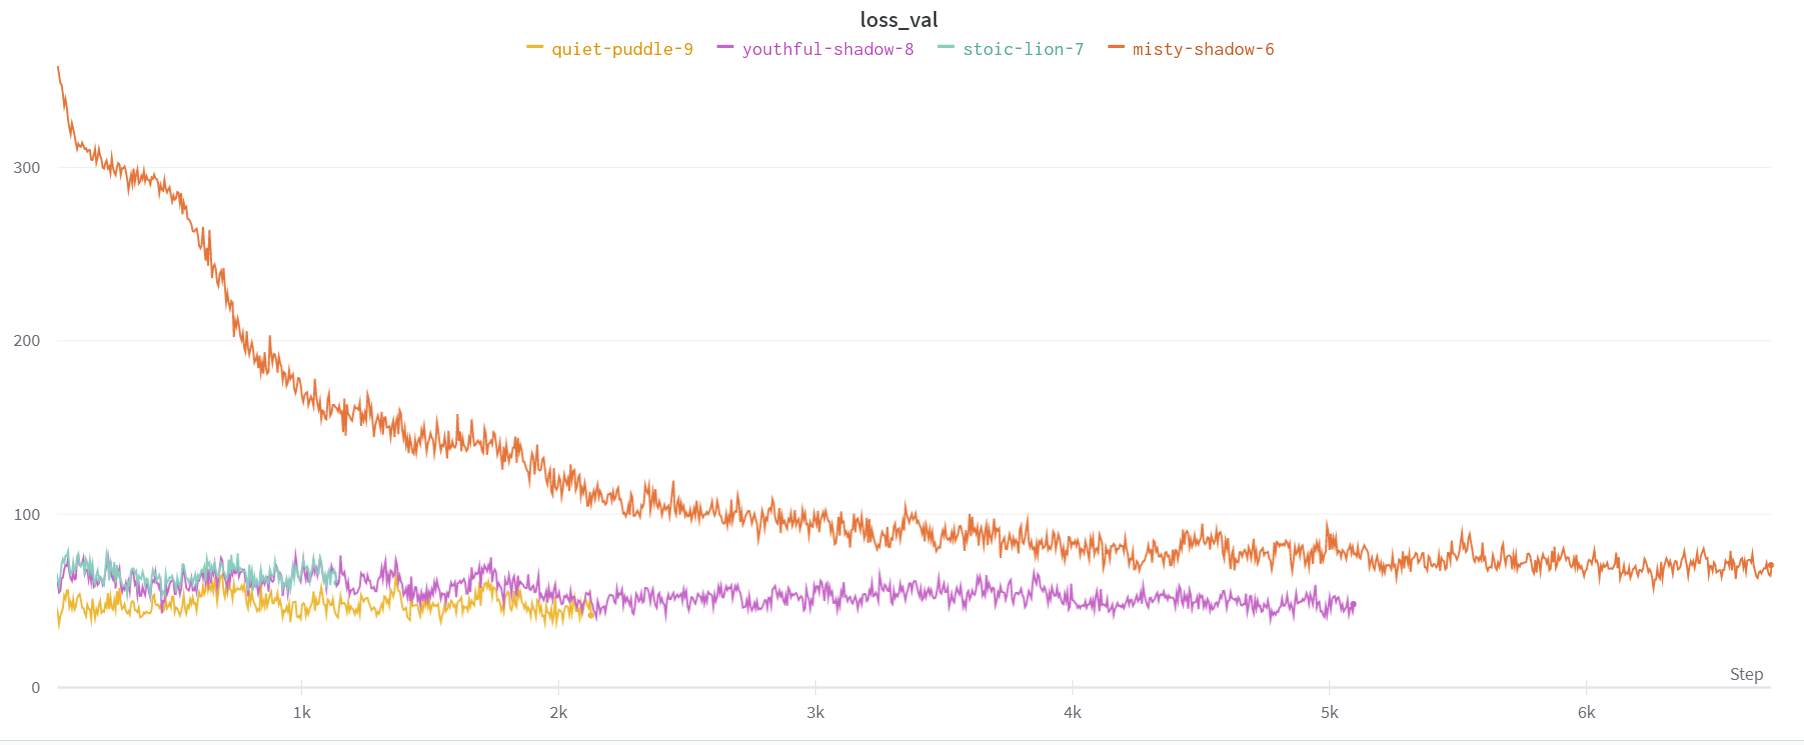

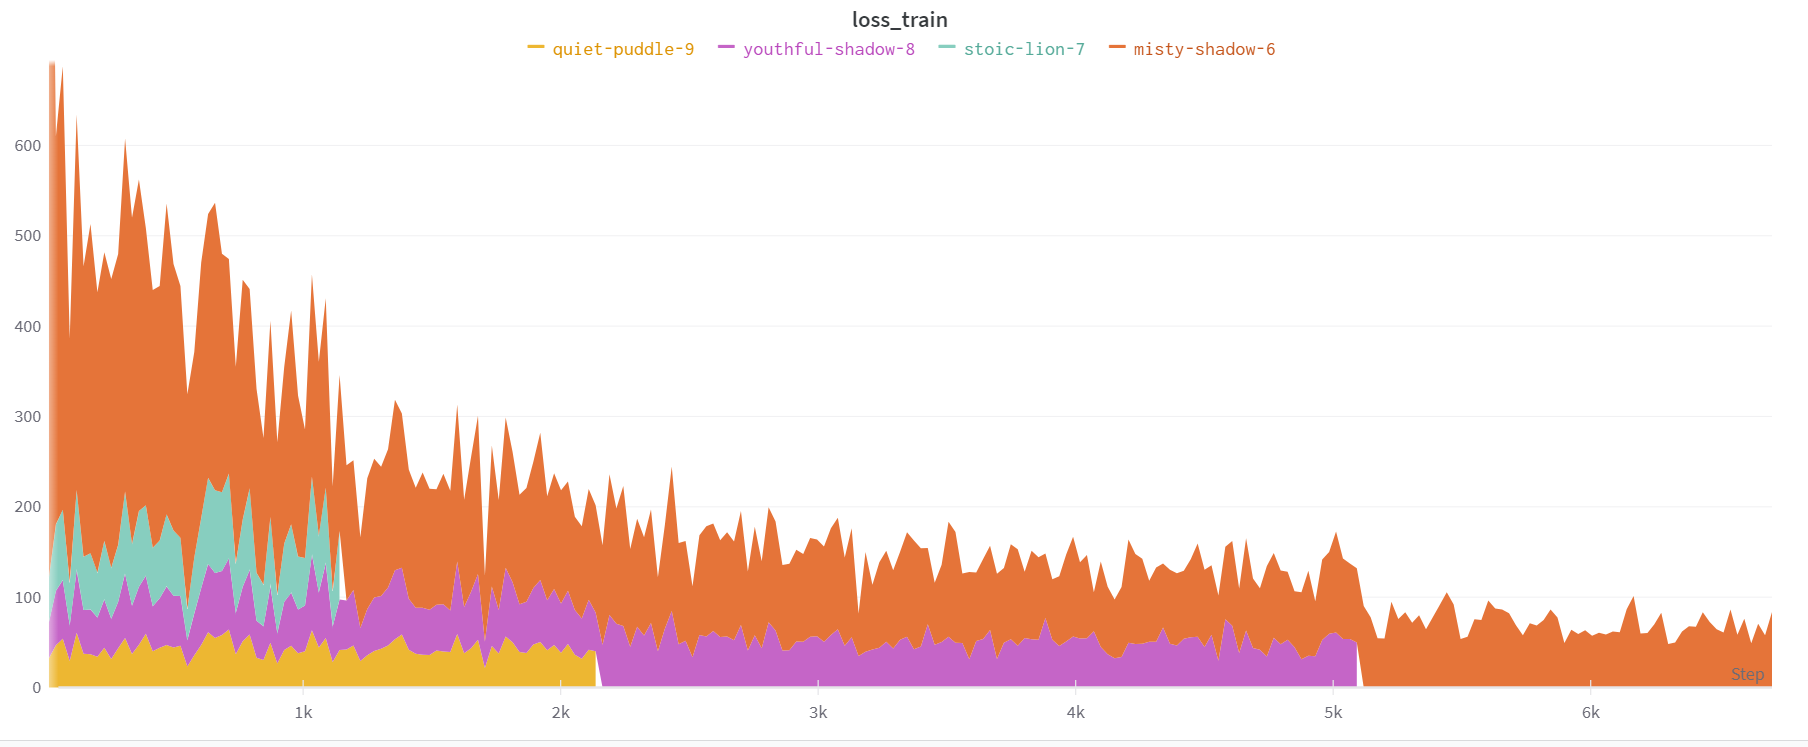

In [ ]:
test(model, device, test_loader, criterion, epoch)